In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg19
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [513]:
from torch.autograd import Variable

In [541]:
x = Variable(torch.Tensor([[1., 1.]]), requires_grad=True)
y = Variable(torch.Tensor([[1., 1.]]), requires_grad=True)

In [546]:
z = torch.cat([x,y], 1)
z.shape

torch.Size([1, 4])

In [547]:
target = Variable(torch.Tensor([2., 2., 2., 2.]), requires_grad=True)

In [548]:
loss = torch.mean(z - target)

In [549]:
loss.backward()

In [551]:
x.grad

tensor([[0.2500, 0.2500]])

# Vision Transformer

In [202]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [614]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.embeddingLayer = nn.Conv2d(3, 64, 16, 16)
#         self.positionalEncoding = PositionalEncoding(64, max_len=196)
        self.transformerEncoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(64, 8, 64, activation="gelu"), 6)
        cls_tensor = torch.randn(1,1,64, requires_grad=True)
        self.gls = nn.Parameter(cls_tensor)
#         mask_token = torch.randn(1,1,64)
#         self.mask_token = nn.Parameter(mask_token)

#     def forward(self, x, unmasked, masked, swapped):
    def forward(self, x):
        x = self.embeddingLayer(x)
                
        n, c, w, h = x.shape
        x = torch.reshape(x, [n, h * w, c])
        
#         swapped_embedding_ids = unmasked[:len(swapped)]
#         swapped_embeddings = x[:,swapped_embedding_ids,:]
#         x[:,swapped_embedding_ids,:] = swapped_embeddings
        
#         x[:,masked,:] = self.mask_token
        
#         x = self.positionalEncoding(x)

#         cls = torch.cat((self.gls.repeat(n,1,1), x), 1)
# #         print(cls.grad_fn)
#         x = torch.cat((self.gls.repeat(n,1,1), x), 1)
#         print(x[:,0,:].requires_grad)
#         new_t = torch.rand(32,1,64, requires_grad=True)
#         cls = self.gls.repeat(32,1,1)
#         gps = torch.cat([new_t,cls], 1)
        cls = self.gls.repeat(32,1,1)
        new_t = torch.rand(16,1,64, requires_grad=True)
        print(x.requires_grad)
        gps = torch.cat([cls,x], 1)
        print(gps.shape, "gps")

#         x = x + self.gls
        x = self.transformerEncoder(gps)
        return x

In [537]:
test = torch.rand(10, 3, 244, 244)
vision_transformer = VisionTransformer()
res = vision_transformer(test, [1,2,3], [4], [5], [6])
res.shape

TypeError: forward() takes 2 positional arguments but 6 were given

# Raw feature extractor

In [5]:
vgg = vgg19(pretrained=True)

In [622]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = nn.Sequential(*list(vgg.features.children())[:3])

#     def forward(self, x, y, masked_patches):
    def forward(self, x, y):
#         masked_patches_dims = []
#         for masked_patch in masked_patches:
#                 height_offset = 16 * ((masked_patch) // 2)
#                 width_offset = 16*((masked_patch) % 2)
#                 masked_patches_dims.append([height_offset,width_offset])
        
#         target_patches = []
#         for target in range(y.shape[0]):
#             for masked_patch in masked_patches_dims:
#                 height_offset, width_offset = masked_patch
#                 extracted_patch = y[target,:,height_offset:height_offset + 16,width_offset:width_offset + 16]
#                 target_patches.append(extracted_patch)

#         target_patches_tensor = torch.stack(target_patches)
        target_patches_tensor = self.feature_extractor(y[:,:,0:16,0:16])
        print(target_patches_tensor.shape)
        target_patches_tensor = F.avg_pool2d(target_patches_tensor, 16, 1)
        target_patches_tensor = target_patches_tensor.view(target_patches_tensor.shape[0],64)
        
#         masked_patches_shifted = [masked_patch + 1 for masked_patch in masked_patches]
#         x = x[:,masked_patches_shifted,:]
#         x = x.view(target_patches_tensor.shape[0], 64)
        x = x[:,1,:].view(target_patches_tensor.shape[0], 64)
        
        loss = F.mse_loss(x, target_patches_tensor)
        return loss

In [412]:
p = PerceptualLoss()
y = torch.rand(2, 3, 32, 32)
x = torch.rand(2,4, 64)
p(x, y, 3)

TypeError: forward() takes 3 positional arguments but 4 were given

# Train loader

In [413]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224))
])

In [555]:
dataset = datasets.ImageFolder('../data', transform=transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32)

In [556]:
len(train_loader)

157

In [557]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

# Training step

In [623]:
def train(model, loss_fn, device, train_loader, optimizer, epoch):
    patches = list(range(14))
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        np.random.shuffle(patches)
#         masked_patches = patches[:len(patches)//2]
#         unmasked = [patch for patch in patches if patch not in masked_patches]
#         tokenized, swapped, unchanged = np.split(masked_patches, [int(.8*len(masked_patches)),
#                                                                   int(.9*len(masked_patches))])
        optimizer.zero_grad()
#         output = model(data, unmasked, masked_patches, swapped)
        output = model(data)
#         loss = loss_fn(output, data, masked_patches)
        loss = loss_fn(output, data)
#         loss = F.mse_loss(output,torch.rand(32,392,64))
        loss.backward()
        plot_grad_flow(model.named_parameters())
#         for n, p in model.named_parameters():
#             print(n)
#             print(p.grad.abs().mean())
        optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#             print(model.gls)

In [624]:
model = VisionTransformer().to("cpu")
optimizer = optim.Adadelta(model.parameters())
scheduler = StepLR(optimizer, step_size=1)
perceptual_loss = PerceptualLoss()

True
torch.Size([32, 197, 64]) gps
torch.Size([32, 64, 16, 16])


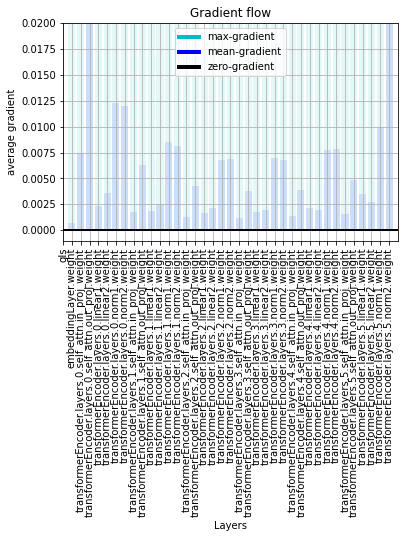

True
torch.Size([32, 197, 64]) gps
torch.Size([32, 64, 16, 16])


KeyboardInterrupt: 

In [625]:
for epoch in range(1, 2):
    train(model, perceptual_loss, "cpu", train_loader, optimizer, epoch)
    scheduler.step()

# Plot grads

In [577]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and (p.grad != None):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    plt.show()